# Aproximación a la curva de Zipf

La ley de Zipf nos dice que dada la frecuencia de una palabra $fr$
y su rango estadístico r , tenemos que:

$$fr∝r^{−α}$$

donde $α$ es un parámetro.

Aquí nos proponemos ver esta distribución y analizar una forma de linearizarla para aproximarla por un método de regresión.

Tomemos un corpus y obtengamos sus rangos y sus frecuencias.

In [1]:
from collections import Counter
from re import sub
from scipy.optimize import minimize as min
import matplotlib.pyplot as plt
import numpy as np

#Abrir el documento
text = open('./../99_corpus/the_silmarillion.txt','r',encoding='utf-8').read()
#Limpiar y tokenizar
tokens = sub(r'[^\w\s]','',text.strip().lower()).split()
#optener frecuencias
frecs = np.array(sorted(Counter(tokens).values(), reverse=True))

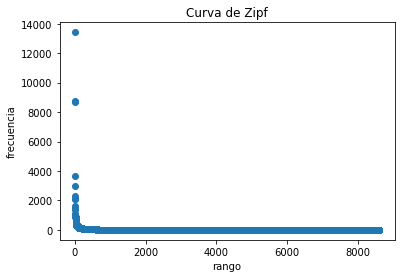

In [2]:
#Obtención de los ranks
ranks = np.array(range(1,len(frecs)+1))

#Ploteo de la curva
plt.scatter(ranks,frecs)
plt.xlabel('rango')
plt.ylabel('frecuencia')
plt.title('Curva de Zipf')
plt.show()

Observamos que, en efecto, la curva así obtenida tiene una forma que recuerda a la función $\frac{1}{x}$. Sin embargo, podemos "linealizar" esta distribución a partir del logaritmo.

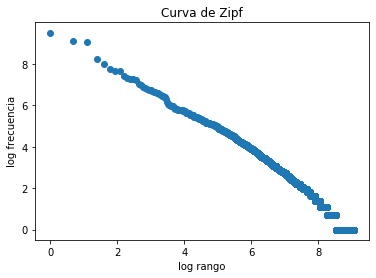

In [3]:
#Obtención de logaritmos
log_ranks = np.log(ranks)
log_frecs = np.log(frecs)

#Ploteo en escala logaritmoca
plt.scatter(log_ranks,log_frecs)
plt.xlabel('log rango')
plt.ylabel('log frecuencia')
plt.title('Curva de Zipf')
plt.show()

## Análisis estadístico

Como se puede observar en la gráfica en escala logarítmica, existe una correlación entre ambas variables. Podemos determinar el valor de dicha correlación a partir de estudiar el comportamiento estadístico de ambas variables. En primer lugar, podemos observar como se comportan las medias empíricas de estas variables. Para determinar esto, simplemente calcularemos:
$$\hat{\mu} = \frac{1}{N} \sum_i X_i$$

In [4]:
#Número de valores
N = len(log_ranks)
#Media de rangos
m_r = (1./N)*log_ranks.sum(0)
#Media de frecuencias
m_f = (1./N)*log_frecs.sum(0)

print('Media empírica de log rangos:', m_r)
print('Media empírica de log frecuencias:', m_f)

Media empírica de log rangos: 8.061196415636504
Media empírica de log frecuencias: 1.1258203505064932


A partir de la media podemos determinar el valor de la varianza empírica. Esta esta definida como sigue:
$$\hat{var} = \frac{1}{N}\sum_i (X_i - \hat{\mu})^2$$

Y a partir de la varianza podemos determinar la desviación estándar empírica en los siguientes términos.
$$\hat{\sigma} = \sqrt{\hat{var}}$$

In [5]:
#Varianza rangos
v_r = (1./N)*((log_ranks-m_r)**2).sum(0)
#Varianza frecuencias
v_f = (1./N)*((log_frecs-m_f)**2).sum(0)

#Desviación estándar rangos
s_r = np.sqrt(v_r)
#Desviación estándar frecuencias
s_f = np.sqrt(v_f)

print('Desviación estándar log rangos:', s_r)
print('Desviación estándar log frecuencias:', s_f)

Desviación estándar log rangos: 0.9971611200766629
Desviación estándar log frecuencias: 1.3342737051813764


Finalmente, a partir de estos valores podemos definir un índice de correlación (la correlación de Pearson) a partir de la siguiente fórmula:
$$\rho(X,Y) = \frac{1}{N}\frac{\sum_i (X_i-\mu_X)(Y_i - \mu_Y)}{\hat{\sigma_X}\hat{\sigma_Y}}$$

In [6]:
cov = (1./N)*np.dot(log_ranks-m_r,log_frecs-m_f)
corr = cov/(s_r*s_f)

print('Correlación log rangos-log frecuencias:', corr)

Correlación log rangos-log frecuencias: -0.9863959045105724


Este índice de correlación aúnta que las variables de rango y aprendizaje se relacionan fuertemente de manera negativa. Es decir, es inversamente proporcional (lo que señala la ley de Zip), entre más crezca el logaritmo del rango, decrece el logaritmo de la frecuencia. De tal forma, que, podemos tomar esta correlación como un parámetro de tal forma que:
$$\log fr \approx \rho(r,fr)\log r$$

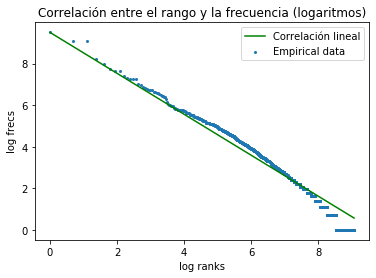

In [7]:
plt.scatter(log_ranks,log_frecs, label='Empirical data', s=4)
plt.plot(log_ranks,corr*log_ranks+ log_frecs[0], color='g', label='Correlación lineal')
plt.title('Correlación entre el rango y la frecuencia (logaritmos)')
plt.xlabel('log ranks')
plt.ylabel('log frecs')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

## Estimación por minimización

Esta es la forma común de observar la distribución de Zipf, pues en escala logarítmica, podemos decir que existe una dependencia lineal entre las palabras.

Así, podemos definir una función para aproximar esta distribución, dada por:
$$\log \hat{fr} = q \log r + \log b$$

Donde $b$ es la mayor frecuencia en los datos. En este caso, $q$ es un parámetro que aproxima la frecuencia en escala logaritmica.

Para encontrar el valor de $q$ definiremos el error cuadrático medio como:
$$MSE(q) = \sum_r || \log \hat{fr} - log fr||^2$$

Iniciamos el valor de $q=1$ y calculamos su MSE.

In [8]:
#Función de minimización
func = lambda a: sum(((a*log_ranks + log_frecs[0])-log_frecs)**2)
#Inicialización
a0 = 1

print(func(a0))

2373255.1653848984


Ya que esta función es lineal, podemos ver el problema de minimizar este error como una regresión lineal y así aproximar un valor de $q$ que minimice el error:

In [9]:
#Minimización
a_hat = min(func, a0).x[0]

print('valor:',a_hat, '\nMSE:',func(a_hat))

valor: -1.0436205529827496 
MSE: 1077.421027481514


Claramente, se trata de un valor negativo, pues la recta es descendiente (tiene pendiente negativa). Para ver que también se aproxima, podemos graficar la aproximación y los valores originales.

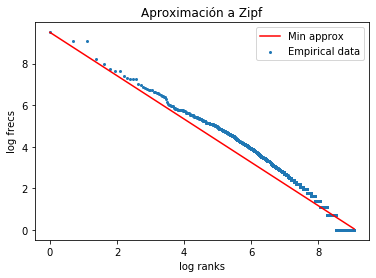

In [10]:
plt.scatter(log_ranks,log_frecs, label='Empirical data', s=4)
plt.plot(log_ranks,a_hat*log_ranks+ log_frecs[0], color='r', label='Min approx')
plt.title('Aproximación a Zipf')
plt.xlabel('log ranks')
plt.ylabel('log frecs')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

Tenemos además que resolviendo la función:
$$exp[\log \hat{fr}] = exp[q \log r + \log b]$$

Obtenemos que:
$$\hat{fr} = br^q$$

Ya que el valor es negativo, podemos tomar $q = -\alpha$, con $α$ positivo, y de esta forma tenemos que $\hat{fr} = \frac{b}{r^\alpha}$, ya que $b$ es una constante, tenemos que $\hat{fr} \propto \frac{1}{r^\alpha} = r^q$.

Es decir, hemos encontrado una aproximación al parámetro α
de la distribución de Zipf.

## Comparación de funciones

Las aproximaciones a la frecuencia de las palabras pueden variar. Así, diferentes funciones de probabilidad pueden calcularse. Un enfoque común, es la probabilidad frecuentista, donde la función de probabilidad se calcula como:
$$p_{fr}(w) = \frac{fr(w)}{N}$$

Donde $N=\sum_{w'}fr(w')$ es el total de tokens en el corpus.

In [11]:
N = sum(frecs)
p_fr = np.array([float(fr)/N for fr in frecs])
print(p_fr.sum(0))

1.0


En la función de probabilidad de la distribución Zipf, es común tomar el parámetro $\alpha=1$. De tal forma que:
$$p_z(r; \alpha=1)= \frac{r^{-1}}{\sum_{k} k^{-1}}$$

In [12]:
p_zipf1 = 1./np.array(ranks)
p_zipf1 = p_zipf1/p_zipf1.sum(0)
print(p_zipf1.sum(0))

0.9999999999999998


Finalmente, la aproximación del parámetro usando MSE se determina como:
$$p_z(r; \alpha)= \frac{r^{\alpha}}{\sum_{k} k^{\alpha}}$$

In [13]:
p_zipf_ap = ranks**a_hat
p_zipf_ap = p_zipf_ap/p_zipf_ap.sum(0)
print(p_zipf_ap.sum(0))

1.0


Tambiém podemos utilizar el coeficiente de correlación para estimar la probabilidad en la distribución de Zipf.

In [14]:
p_zipf_corr = ranks**corr
p_zipf_corr = p_zipf_corr/p_zipf_corr.sum(0)
print(p_zipf_corr.sum(0))

0.9999999999999999


De esta forma, contamos con varias funciones de probabilidad. Por tanto, podemos medir la divergencia entre estas funciones de probabilidad. Si $q$ y $p$ son funciones de probabilidad sobre la misma variable, entonces, calculamos la divergencia de Kullbakc-Leibler como:
$$D[q||p] = \sum_x q(x) \log \frac{q(x)}{p(x)}$$

In [15]:
#Divergencia KL
D_kl = lambda q,p: (q*np.log(q/p)).sum(0)

Podemos obtener las divergencias entre cada uno de las funciones de probabilidad:

In [16]:
print( 'Divergencia frecuencia relativa y Zipf con a=1 \t', D_kl(p_fr,p_zipf1) )
print( 'Divergencia frecuencia relativa y Zipf MSE approx \t',D_kl(p_fr,p_zipf_ap) )
print( 'Divergencia correlación y Zipf MSE approx \t',D_kl(p_zipf_corr,p_zipf_ap) )
print( 'Divergencia Zipf con a=1 y MSE approx \t',D_kl(p_zipf1,p_zipf_ap) )

Divergencia frecuencia relativa y Zipf con a=1 	 0.03363895032105993
Divergencia frecuencia relativa y Zipf MSE approx 	 0.03231551351434174
Divergencia correlación y Zipf MSE approx 	 0.01251020062102591
Divergencia Zipf con a=1 y MSE approx 	 0.007262057768491179


De igual forma podemos determinar la entropía cruzada empírica para cada una de las funciones de probabilidad de la forma:
$$H_E(X,p) = -\frac{1}{N} \sum_{i=1}^N \log p(x_i)$$

In [17]:
#Entropía cruzada empírica
H_E = lambda p: -np.log(p).sum(0)/len(p)

In [18]:
print( 'Prob. frecuentista \t', H_E(p_fr) )
print( 'Prob. Zipf con a=1 \t', H_E(p_zipf1) )
print( 'Prob. Zipf correlación \t', H_E(p_zipf_corr) )
print( 'Prob. Zipf MSE aprox. \t', H_E(p_zipf_ap) )

Prob. frecuentista 	 10.81940687652546
Prob. Zipf con a=1 	 10.326893141119092
Prob. Zipf correlación 	 10.275772749278014
Prob. Zipf MSE aprox. 	 10.500339202636821


Visualmente, podemos observar cómo es que las estimaciones hechas se ajustan a la recta en escala logarítmica.

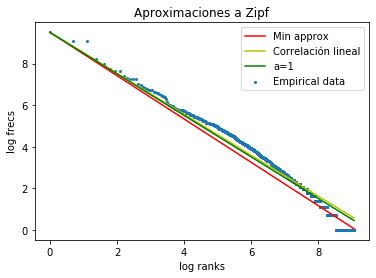

In [19]:
plt.scatter(log_ranks,log_frecs, label='Empirical data', s=4)
plt.plot(log_ranks,a_hat*log_ranks+ log_frecs[0], color='r', label='Min approx')
plt.plot(log_ranks,corr*log_ranks+ log_frecs[0], color='y', label='Correlación lineal')
plt.plot(log_ranks,-log_ranks+ log_frecs[0], color='g', label='a=1')
plt.title('Aproximaciones a Zipf')
plt.xlabel('log ranks')
plt.ylabel('log frecs')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

En general, minimizar el error cuadrático medio equivale a minimizar la entropía cruzada empírica; por tanto, la función de probabilidad obtenida con el método de MSE tiene la menor entropía cruzada emprica.

*Nota:* Esta conclusión no es necesariamente correcta ya que se u tilizo un corpus distinto al del profesor Mijangos, en este caso podemos decir que la de $a=1$ y la correlación lineal tiene la menor entropia cruzada empirica.